# Boston Housing Dataset  

설명: 지역별 범죄율, 방 개수, 교통 접근성 등을 이용해 주택 가격을 예측하는 회귀 문제 분석 과정

### Outline (분석 과정)

데이터 로드 및 전처리  
>- Boston Housing Dataset 불러오기  
>- 변수 설명 및 결측치/중복 확인  
>- 이상치 존재 여부 확인  

EDA  
>- MEDV(주택 가격) 분포 확인  
>- 각 특성의 분포 시각화 및 이상치 탐색/제거 (마지막에 제거한거랑 비교) 
>- 상관관계 분석 및 회귀선 시각화  

이상치 처리 및 정규화  
>- IQR 기반 이상치 탐지  
>- 제거 시 데이터 수 급감 → 제거하지 않음  
>- MinMax Scaling 적용  

모델 학습 및 평가  
>- 기본 모델: `Linear Regression`  
>- 고급 모델: `Random Forest`, `XGBoost`, `LightGBM`  
>- 딥러닝 모델: `MLP` (PyTorch 기반)  

성능 비교  
>- 평가 지표: `R²`, `Adjusted R²`, `Cross-Validation R²`, `RMSE`  
>- XGBoost 성능 가장 우수  
>- Linear Regression 성능 가장 낮음  
>- 이상치 제거한 경우 성능 저하 → 데이터 감소 영향


In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics

## Data Load

>각 레코드는 보스턴 교외 또는 도시를 설명.  
>데이터는 1970년 보스턴 표준 대도시 통계 지역(SMSA)에서 수집
>
>  - `CRIM`     : 도시별 1인당 범죄율
>  - `ZN`       : 25,000 평방피트 이상 주거용 토지 비율
>  - `INDUS`    : 도시별 비소매업 비즈니스 면적 비율
>  - `CHAS`     : 찰스강 더미 변수(강과 접하면 1, 아니면 0)
>  - `NOX`      : 질소산화물 농도(1천만분의 1)
>  - `RM`       : 주택당 평균 방 개수
>  - `AGE`      : 1940년 이전에 지어진 소유주택 비율
>  - `DIS`      : 5개 보스턴 고용센터까지의 가중 거리
>  - `RAD`      : 방사형 고속도로 접근성 지수
>  - `TAX`      : 1만 달러당 재산세율
>  - `PTRATIO`  : 도시별 학생-교사 비율
>  - `B`        : 1000(Bk - 0.63)^2 (Bk: 흑인 비율)
>  - `LSTAT`    : 저소득층 인구 비율(%)
>  - `MEDV`     : 소유주택의 중앙값(천 달러 단위)
>
>결측치: 없음
>
>중복 데이터: 없음

> 처음에는 train 데이터를 불러온 뒤, 기본 정보와 결측치 여부, 레이블 분포 등을 확인함.  
> 각 feature를 하나하나 뜯어보며 어떻게 변형할 수 있을지 전략을 세움.

In [28]:
data = pd.read_csv("data/HousingData.csv")
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [29]:
data.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,NaN,2.5050,1,273,21.0,396.90,7.88,11.9


In [30]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


## Data Preprocessing(데이터 전처리)
### Missing Value Handling (결측치 처리)
>- 결측치는 모델 학습 시 정보 손실을 야기하고 예측 정확도를 저하시킬 수 있어 필요
>- Method:
>   1. 결측치 비율이 극히 낮으면 해당 레코드 삭제
>   2. 비율이 높거나 중요한 변수인 경우, 평균/중앙값 대체, 회귀 기반 대체, KNN 대체 등을 활용
>- 여기서는 1번 방식 사용

In [32]:
# 결측치 확인
print(data.isnull().sum())

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64


여러 열(CRIM, ZN, INDUS, CHAS, AGE, 그리고 LSTAT)에 결측값(null 값)이 존재.  
따라서 이러한 결측값을 새로운 값으로 채워 결측치 제거.  
여기선, 각 열의 평균값을 사용하여 결측값을 대체

In [33]:
# 평균값으로 채우기
data["CRIM"].fillna(data["CRIM"].mean(),inplace=True)
data["ZN"].fillna(data["ZN"].mean(),inplace=True)
data["INDUS"].fillna(data["INDUS"].mean(),inplace=True)
data["CHAS"].fillna(data["CHAS"].mean(),inplace=True)
data["AGE"].fillna(data["AGE"].mean(),inplace=True)
data["LSTAT"].fillna(data["LSTAT"].mean(),inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


이제 EDA 진행

## EDA

MEDV: (주택 중간 가격, $1000 단위)를 시각화

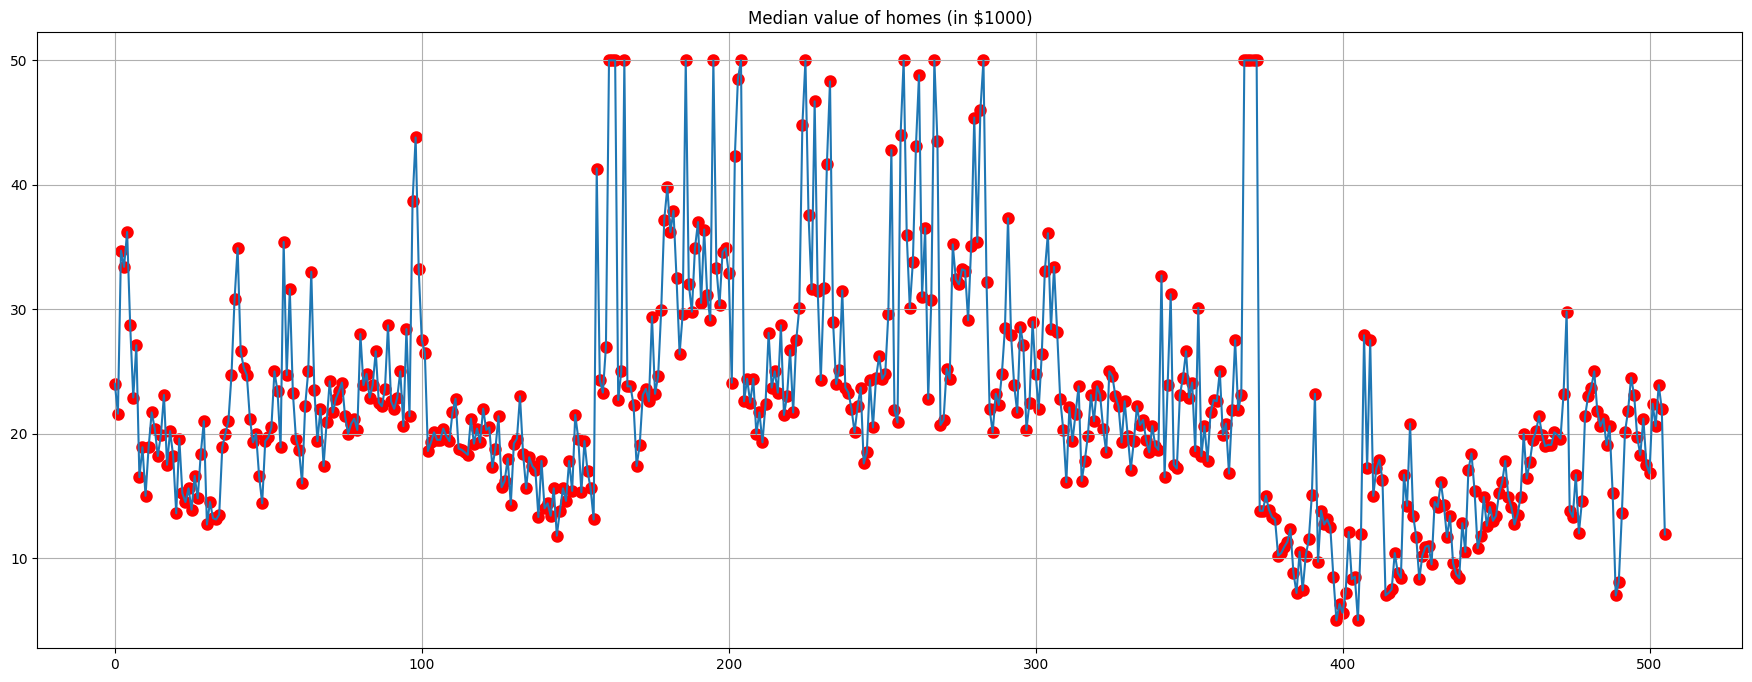

In [34]:
plt.figure(figsize=(22,8))
plt.scatter(data.index,data["MEDV"],color="red",lw=3)
plt.plot(data.index,data["MEDV"])
plt.title("Median value of homes (in $1000)")
plt.grid(True)
plt.show()

>값들이 매우 넓게 분포, 명확한 패턴은 보이지 않음.  
>대부분의 값은 $20,000~$25,000 사이에 분포.  
> 최고 주택 가격은 `$50,000`이며 최저 가격은 약 `$5,000`

다음으로, 모든 특성(feature)의 frequency plot를 보고 어떻게 수정해야할지 확인

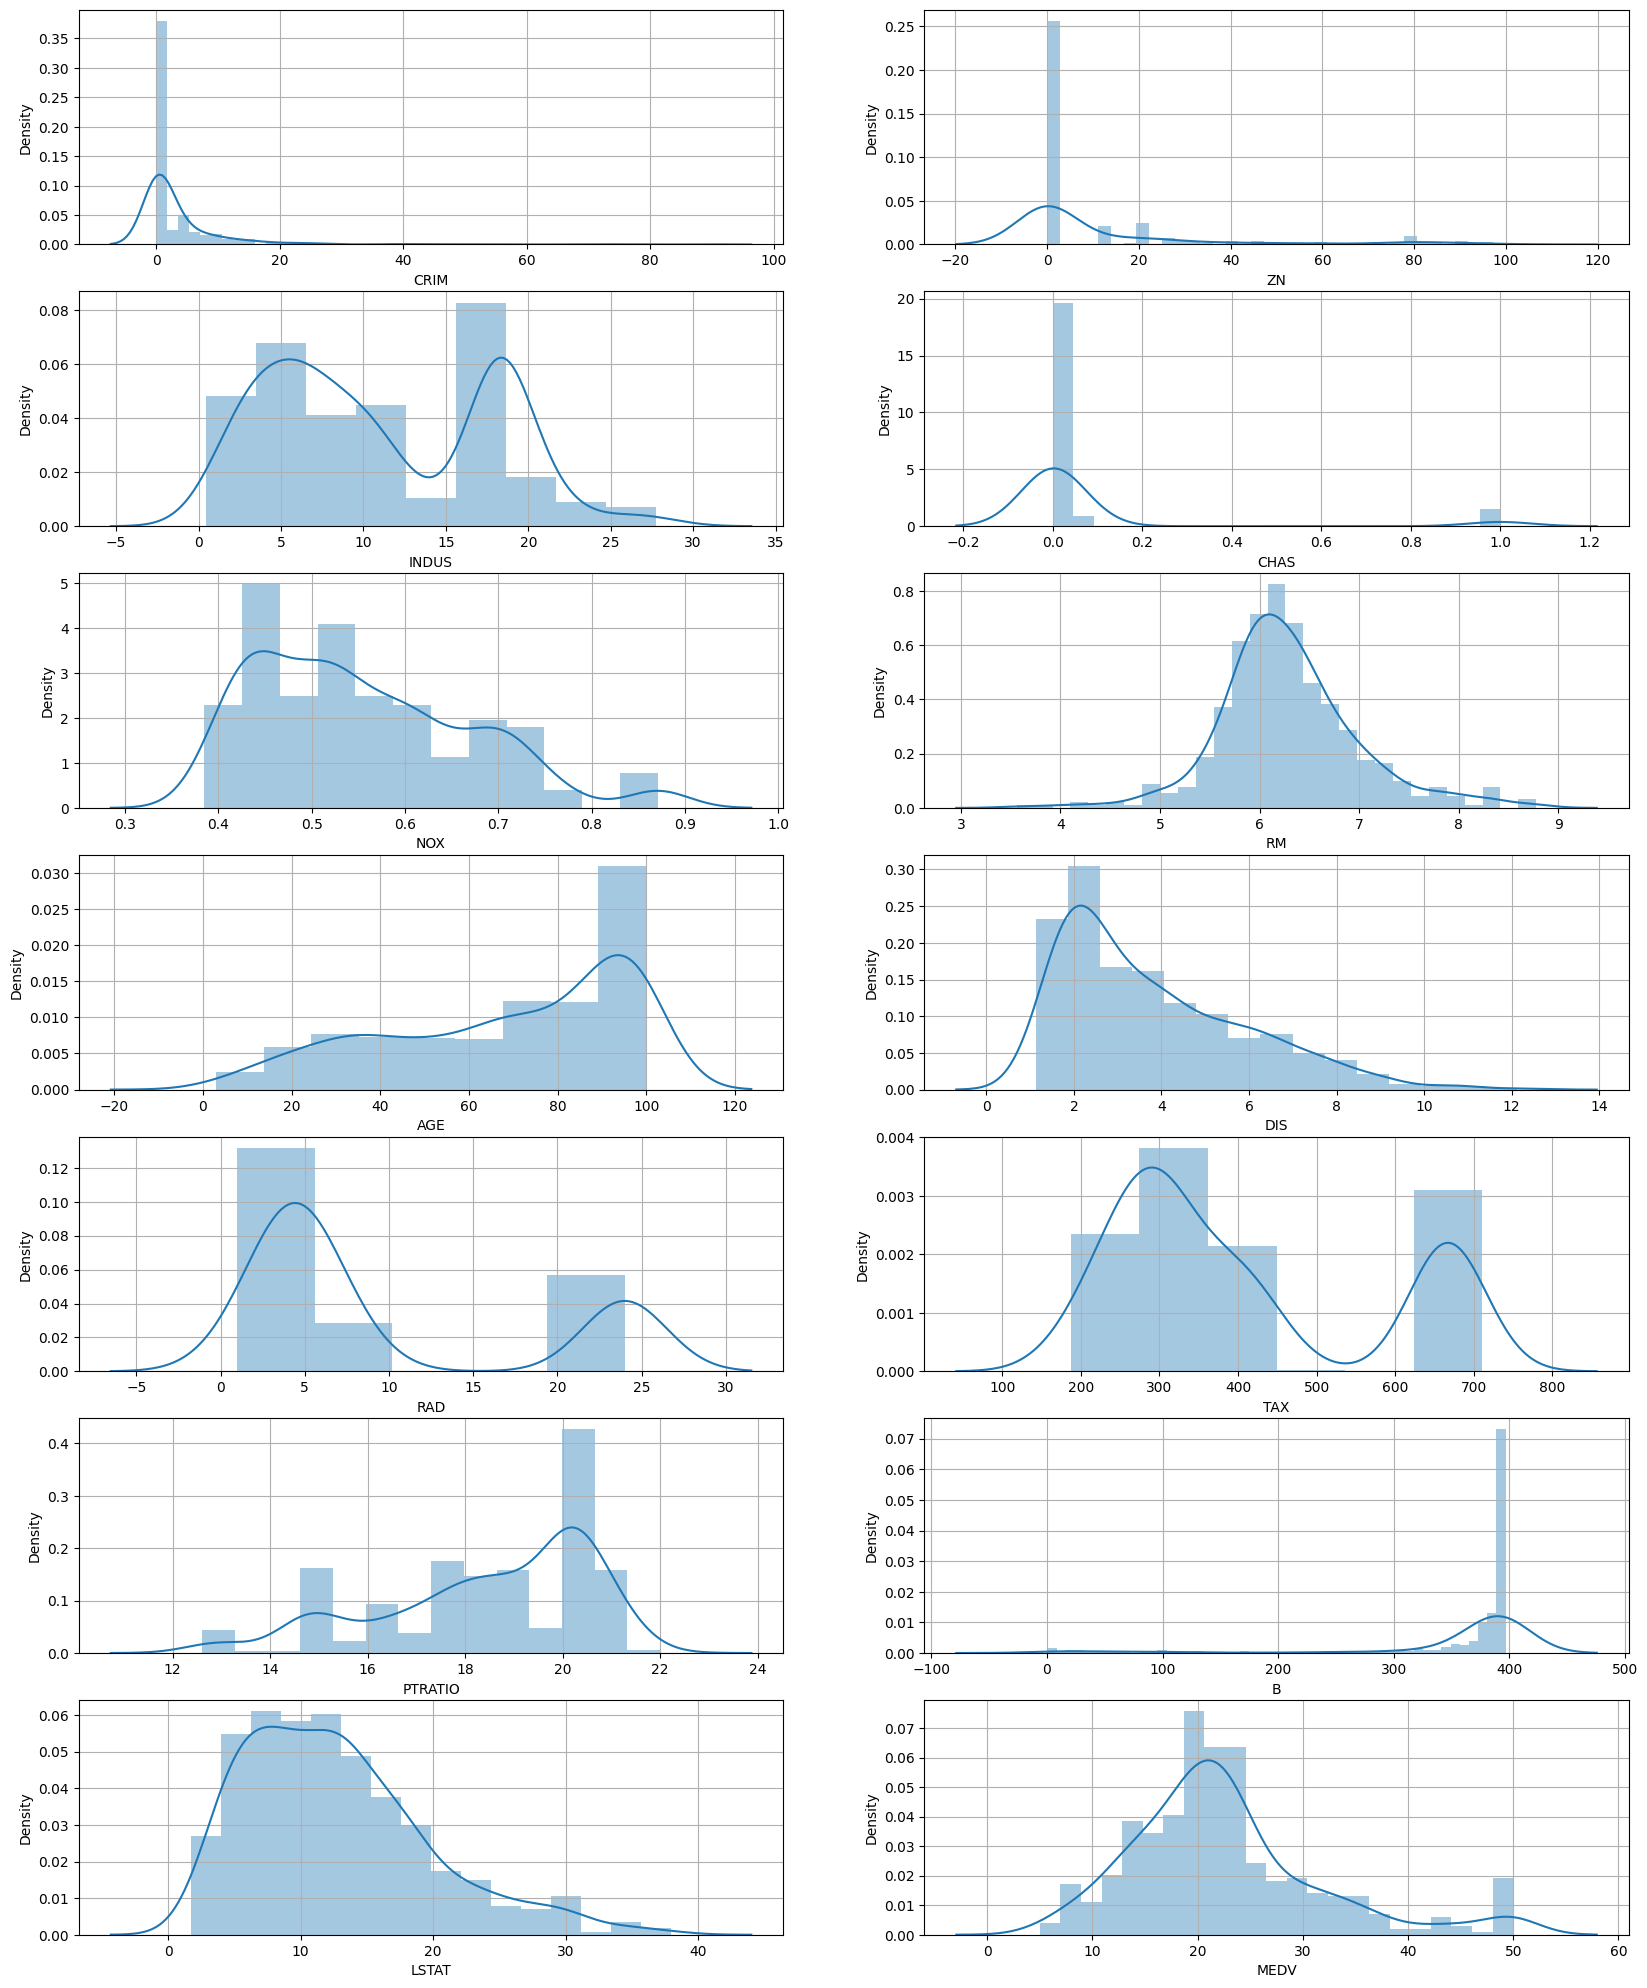

In [35]:
fig, ax1 = plt.subplots(7,2, figsize=(20,25))
k = 0
columns = list(data.columns)
for i in range(7):
    for j in range(2):
            sns.distplot(data[columns[k]], ax = ax1[i][j])
            ax1[i][j].grid(True)
            k += 1
plt.show()

각 입력 특성과 출력 특성(MEDV) 간의 상관관계를 시각화

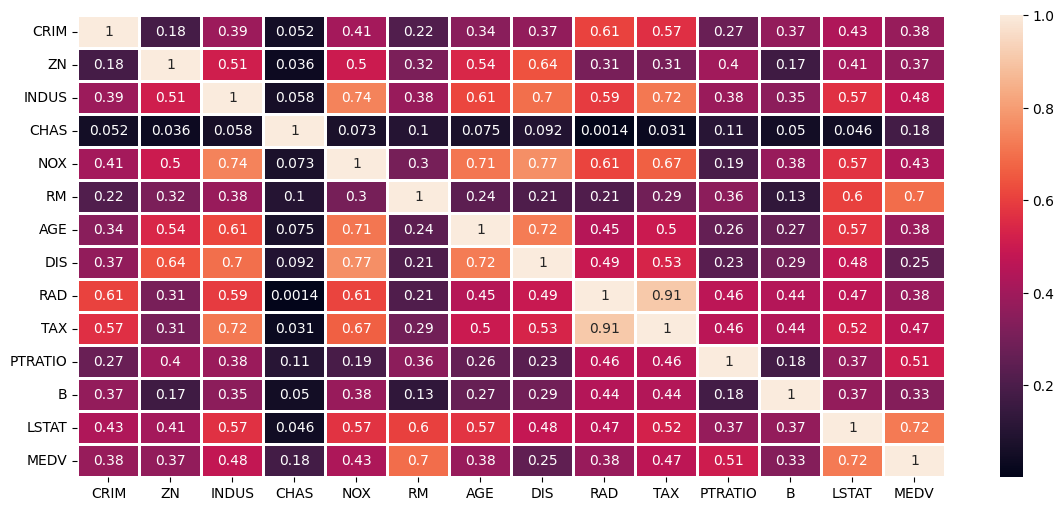

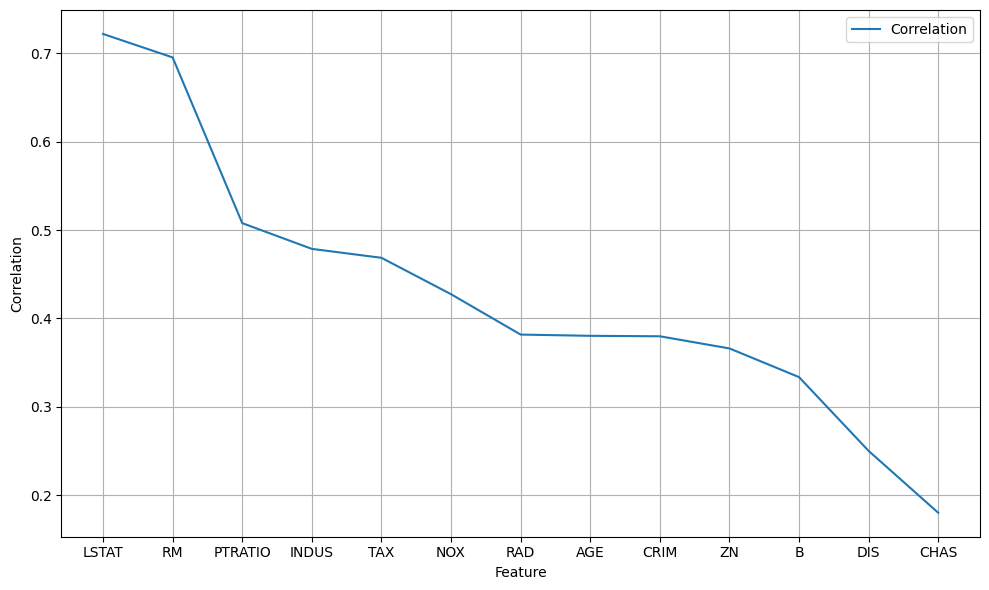

In [37]:
plt.figure(figsize=(14,6))
corr=abs(data.corr())
sns.heatmap(corr,annot=True,linewidth=1)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(corr["MEDV"].sort_values(ascending=False)[1:],label="Correlation")
plt.ylabel("Correlation")
plt.xlabel("Feature")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

`LSTAT(0.72), RM(0.7), PTRATIO(0.51), INDUS(0.48), TAX(0.47)` 는 MEDV와 가장 높은 상관관계를 가지는 것으로 확인  

이 변수들에 대한 회귀 그래프를 그려, response variable과 양의 관계인지 음의 관계인지를 확인


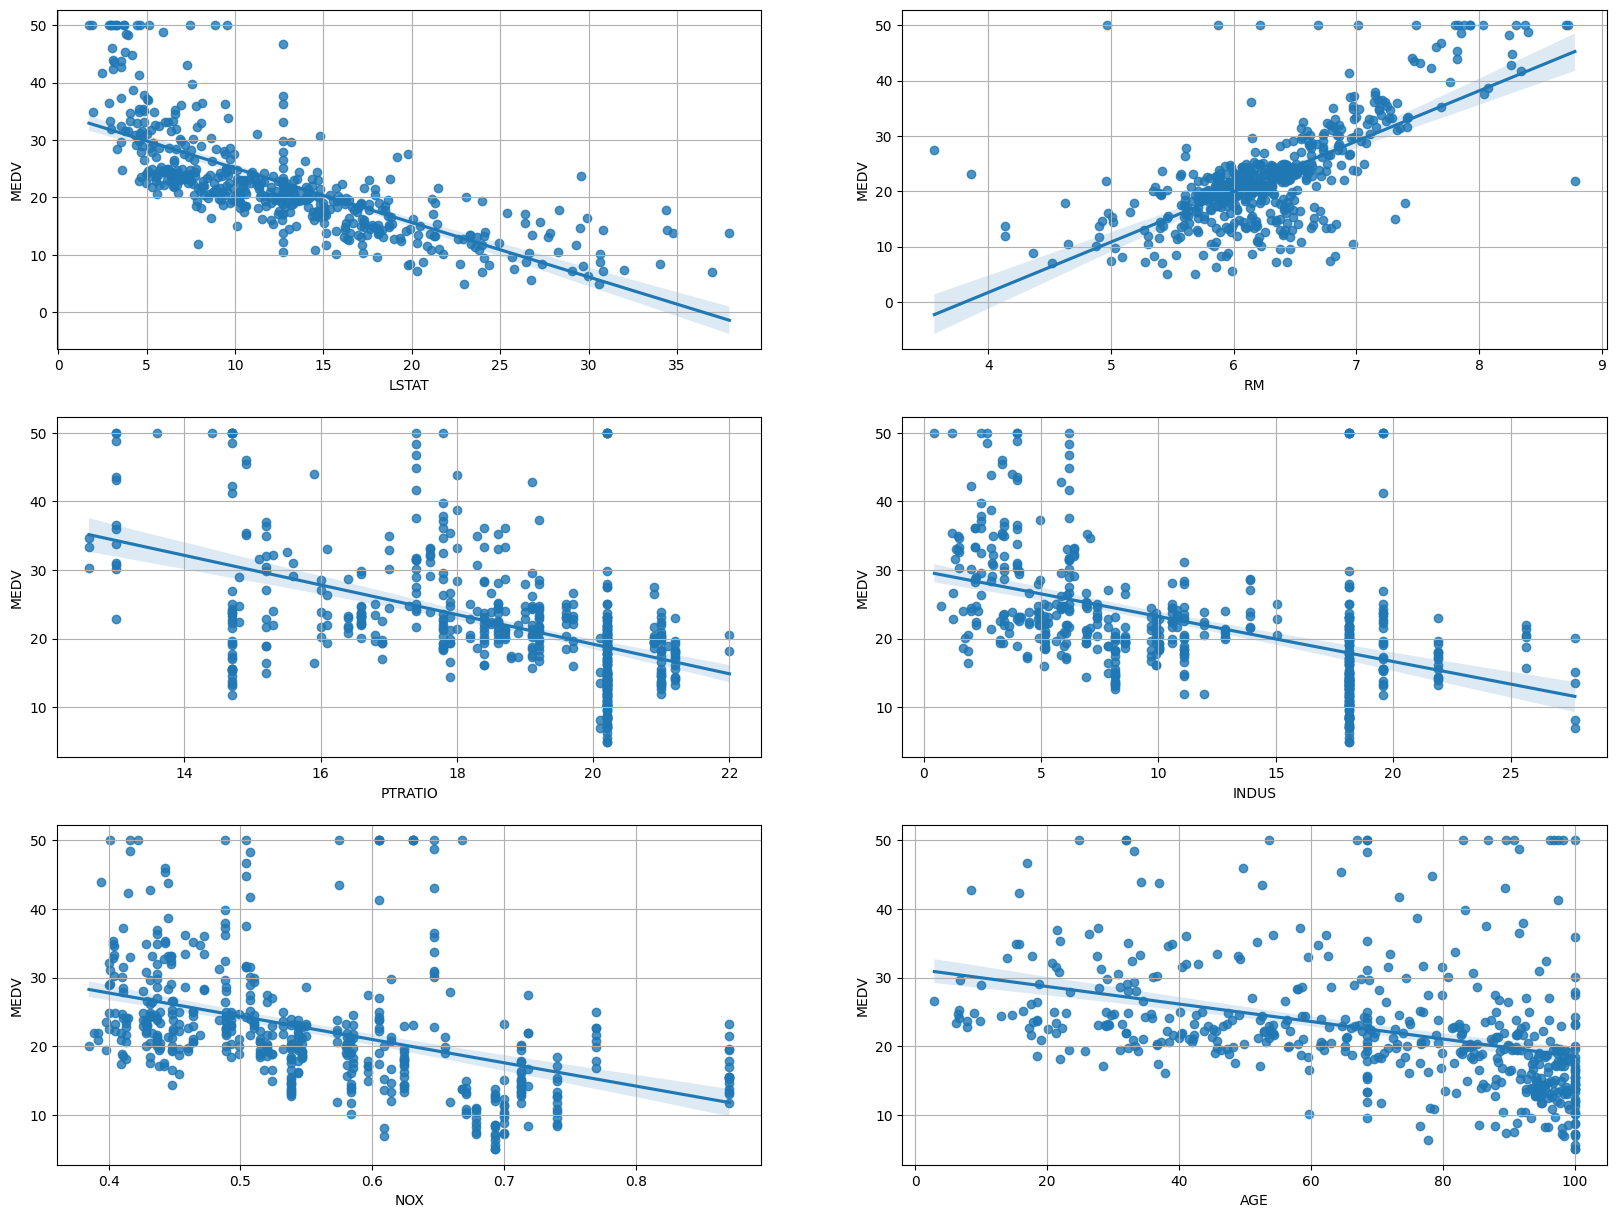

In [38]:
fig, ax1 = plt.subplots(3, 2, figsize=(20, 15))
k = 0
columns = ["LSTAT", "RM", "PTRATIO", "INDUS", "NOX", "AGE"]
for i in range(3):
    for j in range(2):
        sns.regplot(x=data[columns[k]], y=data["MEDV"], ax=ax1[i][j])
        ax1[i][j].grid(True)
        k += 1
plt.show()


각 특성의 박스플롯을 확인하여 이상치가 있는지 파악하고 이를 제거

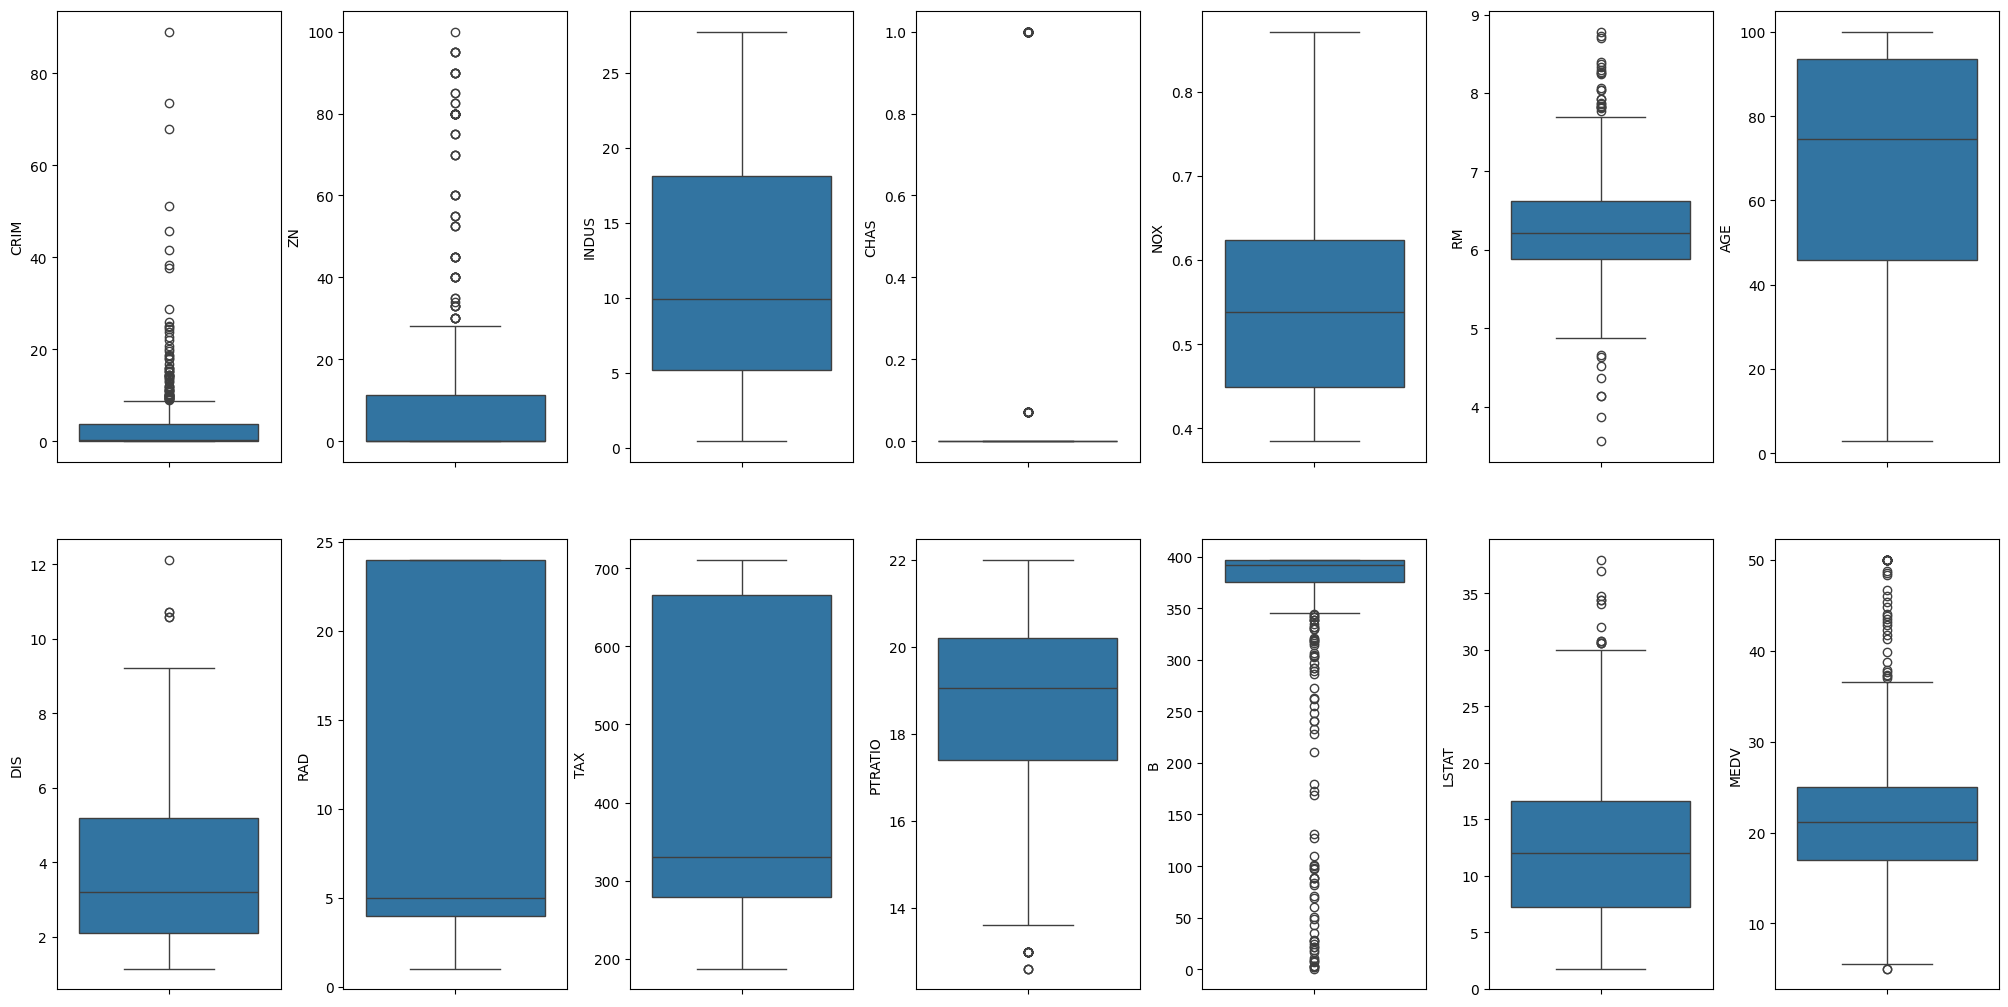

Column CRIM outliers = 12.65%
Column ZN outliers = 13.44%
Column INDUS outliers = 0.00%
Column CHAS outliers = 100.00%
Column NOX outliers = 0.00%
Column RM outliers = 5.93%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.96%
Column B outliers = 15.22%
Column LSTAT outliers = 2.37%
Column MEDV outliers = 7.91%


In [39]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()

for k, v in data.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

`CHAS`: 이상치 100% — 이건 0/1 이진 변수 (더미 변수) 이므로 이상치로 간주하면 안됨.

`CRIM`, `ZN`, `B`: 이상치 비율이 상대적으로 높음 (10% 이상)

`MEDV`, `RM`, `LSTAT`: 모델에 중요한 변수이며 이상치가 있음 (5~8%)

모든 column을 종합했을 때, outlier, influential points를 찾고 제거한 후 scaling 후 학습 진행.


In [40]:
def detect_outliers_iqr(data, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_list_col = data[(data[col] < lower) | (data[col] > upper)].index
        outlier_indices.extend(outlier_list_col)
    return list(set(outlier_indices))

numeric_features = data.columns[:-1]
outliers = detect_outliers_iqr(data, numeric_features)
print(f"제거 전 데이터 크기: {data.shape}")
data2 = data.drop(outliers).reset_index(drop=True)
print(f"제거 후 데이터 크기: {data2.shape}")

제거 전 데이터 크기: (506, 14)
제거 후 데이터 크기: (263, 14)


제거하려 했으나 데이터 수가 너무 많이 줄어들어 제거하지 않고 scaling해서 학습 진행

### 특성 정규화 (Min-Max Scaling)
이상치 제거는 하지 않고, 값의 범위를 통일시켜 모델이 특정 feature에 치우치지 않도록 하기 위해 Min-Max Scaling을 적용함.

In [41]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = data.drop("MEDV", axis=1)
y = data["MEDV"]

X_scaled = scaler.fit_transform(X)
X_scaled

array([[0.00000000e+00, 1.80000000e-01, 6.78152493e-02, ...,
        2.87234043e-01, 1.00000000e+00, 8.96799117e-02],
       [2.35922539e-04, 0.00000000e+00, 2.42302053e-01, ...,
        5.53191489e-01, 1.00000000e+00, 2.04470199e-01],
       [2.35697744e-04, 0.00000000e+00, 2.42302053e-01, ...,
        5.53191489e-01, 9.89737254e-01, 6.34657837e-02],
       ...,
       [6.11892474e-04, 0.00000000e+00, 4.20454545e-01, ...,
        8.93617021e-01, 1.00000000e+00, 1.07891832e-01],
       [1.16072990e-03, 0.00000000e+00, 4.20454545e-01, ...,
        8.93617021e-01, 9.91300620e-01, 1.31070640e-01],
       [4.61841693e-04, 0.00000000e+00, 4.20454545e-01, ...,
        8.93617021e-01, 1.00000000e+00, 1.69701987e-01]])

### Models
> 기본 모델  
> `Linear Regression`
>
> 고급 모델  
> `Random Forest`, `XGBoost`, `LightGBM`
>
> 딥러닝  
> `MLP model`
>
총 5개의 `Linear Regression`, `Random Forest`, `XGBoost`, `LightGBM`, `MLP model` models을 사용해서 비교 

모델 비교 전에 평가 지표부터 정의

### Regression Models Evaluation Metrics (모델 평가 지표)

In [42]:
## 회귀 지표 함수 정의
def Reg_Models_Evaluation_Metrics (model,X_train,y_train,X_test,y_test,y_pred):
    cv_score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
    
    # Adjusted R-squared 계산
    r2 = model.score(X_test, y_test)
    # 관측치 수
    n = X_test.shape[0]
    # 특성(독립변수) 수
    p = X_test.shape[1]
    # Adjusted R-squared 공식
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = model.score(X_test, y_test)
    CV_R2 = cv_score.mean()

    return R2, adjusted_r2, CV_R2, RMSE

> 기본 모델  
`Linear Regression`

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

r2, adj_r2, cv_r2, rmse = Reg_Models_Evaluation_Metrics(lr, X_train, y_train, X_test, y_test, y_pred_lr)
print("Linear Regression → R²:", r2, "Adj R²:", adj_r2, "CV R²:", cv_r2, "RMSE:", rmse)


Linear Regression → R²: 0.6588520195508113 Adj R²: 0.6084551588026357 CV R²: 0.6874851571419403 RMSE: 5.001766890194194


> 고급 모델  
> `Random Forest`, `XGBoost`, `LightGBM`

In [44]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import logging
lgb_logger = logging.getLogger("lightgbm")
lgb_logger.setLevel(logging.CRITICAL)

models = {
    "LightGBM": lgb.LGBMRegressor(verbose=-1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2, adj_r2, cv_r2, rmse = Reg_Models_Evaluation_Metrics(model, X_train, y_train, X_test, y_test, y_pred)
    print(f"{name} → R²: {r2:.4f}, Adj R²: {adj_r2:.4f}, CV R²: {cv_r2:.4f}, RMSE: {rmse:.4f}")


LightGBM → R²: 0.8619, Adj R²: 0.8415, CV R²: 0.8277, RMSE: 3.1826
Random Forest → R²: 0.8874, Adj R²: 0.8708, CV R²: 0.8047, RMSE: 2.8733
XGBoost → R²: 0.9049, Adj R²: 0.8909, CV R²: 0.8223, RMSE: 2.6401


> 딥러닝  
> `MLP model`

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin

# PyTorch MLP 정의
class MLPRegressorTorch(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressorTorch, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# 사이킷런 형식으로 래핑
class MLPWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim, epochs=300, lr=0.001):
        self.input_dim = input_dim 
        self.epochs = epochs
        self.lr = lr
        self.model = MLPRegressorTorch(input_dim)

    def fit(self, X, y):
        self.model.train()
        self.model = self.model.float()
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32)

        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=32, shuffle=True)

        for epoch in range(self.epochs):
            for xb, yb in loader:
                pred = self.model(xb)
                loss = criterion(pred, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            preds = self.model(X_tensor).numpy().flatten()
        return preds

    def score(self, X, y):
        y_pred = self.predict(X)
        return metrics.r2_score(y, y_pred)


5개의 `Linear Regression`, `Random Forest`, `XGBoost`, `LightGBM`, `MLP model` models 성능 비교

In [46]:
# 모델 목록
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror'),
    "LightGBM": lgb.LGBMRegressor(verbose=-1),
    "PyTorch MLP": MLPWrapper(input_dim=X_train.shape[1])
}

# 성능 비교 테이블
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    n = X_test.shape[0]
    p = X_test.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    cv_score = cross_val_score(model, X_train, y_train, cv=10).mean()
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append([name, r2, adjusted_r2, cv_score, rmse])

# 데이터프레임 정리
results_df = pd.DataFrame(results, columns=["Model", "R²", "Adjusted R²", "CV R²", "RMSE"])
results_df = results_df.sort_values(by="R²", ascending=False)
results_df


,Model,R²,Adjusted R²,CV R²,RMSE
2,XGBoost,0.904950,0.890908,0.822332,2.640147
1,Random Forest,0.887422,0.870791,0.804709,2.873284
3,LightGBM,0.861875,0.841470,0.827682,3.182648
4,PyTorch MLP,0.826663,0.801056,0.819699,3.565316
0,Linear Regression,0.658852,0.608455,0.687485,5.001767


결과를 보면 위에서부터 순차적으로 좋다고 볼 수 있음.  
> 가장 좋은 model `XGBoost` 
> 
> 가장 안좋은 model `Linear Regression`
>
만약 딥러닝 모델을 더 복잡하게 만들었다면, 딥러닝 모델에 성능이 가장 좋았을 것 같다!

### 이상치 제거 한 경우 

### 특성 정규화 (Min-Max Scaling)
이상치 제거해서 적용. 그래서 `data`가 아니라 `data2`를 사용

In [47]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = data2.drop("MEDV", axis=1)
y = data2["MEDV"]

X_scaled = scaler.fit_transform(X)
X_scaled.shape

(263, 13)

### Models
> 기본 모델  
> `Linear Regression`
>
> 고급 모델  
> `Random Forest`, `XGBoost`, `LightGBM`
>
> 딥러닝  
> `MLP model`
>
총 5개의 `Linear Regression`, `Random Forest`, `XGBoost`, `LightGBM`, `MLP model` models을 사용해서 비교 

모델 비교 전에 평가 지표부터 정의

### Regression Models Evaluation Metrics (모델 평가 지표)

In [48]:
## 회귀 지표 함수 정의
def Reg_Models_Evaluation_Metrics (model,X_train,y_train,X_test,y_test,y_pred):
    cv_score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
    
    # Adjusted R-squared 계산
    r2 = model.score(X_test, y_test)
    # 관측치 수
    n = X_test.shape[0]
    # 특성(독립변수) 수
    p = X_test.shape[1]
    # Adjusted R-squared 공식
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = model.score(X_test, y_test)
    CV_R2 = cv_score.mean()

    return R2, adjusted_r2, CV_R2, RMSE

> 기본 모델  
`Linear Regression`

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

r2, adj_r2, cv_r2, rmse = Reg_Models_Evaluation_Metrics(lr, X_train, y_train, X_test, y_test, y_pred_lr)
print("Linear Regression → R²:", r2, "Adj R²:", adj_r2, "CV R²:", cv_r2, "RMSE:", rmse)


Linear Regression → R²: 0.23112301877283759 Adj R²: -0.02516930830288322 CV R²: 0.5098349678780314 RMSE: 5.617946145068389


> 고급 모델  
> `Random Forest`, `XGBoost`, `LightGBM`

In [50]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import logging
lgb_logger = logging.getLogger("lightgbm")
lgb_logger.setLevel(logging.CRITICAL)

models = {
    "LightGBM": lgb.LGBMRegressor(verbose=-1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2, adj_r2, cv_r2, rmse = Reg_Models_Evaluation_Metrics(model, X_train, y_train, X_test, y_test, y_pred)
    print(f"{name} → R²: {r2:.4f}, Adj R²: {adj_r2:.4f}, CV R²: {cv_r2:.4f}, RMSE: {rmse:.4f}")


LightGBM → R²: 0.4465, Adj R²: 0.2620, CV R²: 0.6244, RMSE: 4.7666
Random Forest → R²: 0.4421, Adj R²: 0.2562, CV R²: 0.5622, RMSE: 4.7853
XGBoost → R²: 0.5830, Adj R²: 0.4440, CV R²: 0.7096, RMSE: 4.1372


> 딥러닝  
> `MLP model`

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin

# PyTorch MLP 정의
class MLPRegressorTorch(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressorTorch, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# 사이킷런 형식으로 래핑
class MLPWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim, epochs=300, lr=0.001):
        self.input_dim = input_dim 
        self.epochs = epochs
        self.lr = lr
        self.model = MLPRegressorTorch(input_dim)

    def fit(self, X, y):
        self.model.train()
        self.model = self.model.float()
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32)

        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=32, shuffle=True)

        for epoch in range(self.epochs):
            for xb, yb in loader:
                pred = self.model(xb)
                loss = criterion(pred, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            preds = self.model(X_tensor).numpy().flatten()
        return preds

    def score(self, X, y):
        y_pred = self.predict(X)
        return metrics.r2_score(y, y_pred)


5개의 `Linear Regression`, `Random Forest`, `XGBoost`, `LightGBM`, `MLP model` models 성능 비교

In [52]:
# 모델 목록
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror'),
    "LightGBM": lgb.LGBMRegressor(verbose=-1),
    "PyTorch MLP": MLPWrapper(input_dim=X_train.shape[1])
}

# 성능 비교 테이블
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    n = X_test.shape[0]
    p = X_test.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    cv_score = cross_val_score(model, X_train, y_train, cv=10).mean()
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append([name, r2, adjusted_r2, cv_score, rmse])

# 데이터프레임 정리
results_df = pd.DataFrame(results, columns=["Model", "R²", "Adjusted R²", "CV R²", "RMSE"])
results_df = results_df.sort_values(by="R²", ascending=False)
results_df


,Model,R²,Adjusted R²,CV R²,RMSE
2,XGBoost,0.583021,0.444028,0.709601,4.137199
3,LightGBM,0.446504,0.262006,0.624369,4.766574
1,Random Forest,0.442146,0.256194,0.562229,4.785303
4,PyTorch MLP,0.324033,0.098711,0.597509,5.267589
0,Linear Regression,0.231123,-0.025169,0.509835,5.617946


결과 비교
>결과를 보면 적용하지 않았을 때 보다 했을 때 성능이 좋지 않음.
> 
>데이터가 많이 줄어들어 R square 값도 많이 낮아 데이터를 잘 설명하지 못한 것으로 보임.
>  
>추가적으로 RMSE 값도 커졌음!